# Julia is Fast - `@time`, `@elapsed` and `@inbounds`

---

In this notebook, we demonstrate how fast `Julia` is, compared to other dynamically typed languages. 

## Prerequisites

Read the text [Why Julia?](https://github.com/stevengj/julia-mit/blob/master/README.md#why-julia) (3 min)

Read [Performance tips](http://julia.readthedocs.org/en/latest/manual/performance-tips/) section of the `Julia` manual. (20 min) 

## Competences 

The reader should understand effects of "[just-in-time
compiler](https://en.wikipedia.org/wiki/Just-in-time_compilation)"
called [LLVM](http://llvm.org/)`LLVM` on the speed of execution of programs. 
The reader should be able to write simple, but fast, programs containing loops.

## Credits 

Some examples are taken from [The Julia Manual](http://julia.readthedocs.org/en/latest/manual/).


## Scholarly example - summing integer halves

Consider the function `f` which sums halves of integers from `1` to `n`:

__N.B.__ `Esc l` toggles line numbers in the current cell.

In [1]:
function f(n)
    s = 0
    for i = 1:n
        s += i/2
    end
    s
end

f (generic function with 1 method)

In order for the fast execution, the function must first be compiled. Compilation is performed automatically, when the function is invoked for the first time. Therefore, the first call can be done with some trivial choice of parameters.

The timing can be done by two commands, `@time` and `@elapsed`: 

In [2]:
?@time

```
@time
```

A macro to execute an expression, printing the time it took to execute, the number of allocations, and the total number of bytes its execution caused to be allocated, before returning the value of the expression.

See also [`@timev`](:func:`@timev`), [`@timed`](:func:`@timed`), [`@elapsed`](:func:`@elapsed`), and [`@allocated`](:func:`@allocated`).


In [3]:
?@elapsed

```
@elapsed
```

A macro to evaluate an expression, discarding the resulting value, instead returning the number of seconds it took to execute as a floating-point number.

See also [`@time`](:func:`@time`), [`@timev`](:func:`@timev`), [`@timed`](:func:`@timed`), and [`@allocated`](:func:`@allocated`).


In [4]:
@time f(1) 

  0.014257 seconds (2.27 k allocations: 109.386 KB)


0.5

In [5]:
@elapsed f(1)  # This run is much faster, since the function is already compiled

3.265e-6

Let us now run the big-size computation. Notice the unnaturally high byte allocation and the huge amount of time spent on 
[garbage collection](http://en.wikipedia.org/wiki/Garbage_collection_%28computer_science%29).

In [6]:
@time f(1000000) # Notice the unnaturally high byte  allocation!

  0.057721 seconds (3.00 M allocations: 45.777 MB, 22.22% gc time)


2.5000025e11

In [7]:
@elapsed f(1000000) # We shall be using @time from now on

0.04486171

> Since your computer can execute several _Gigaflops_ (floating-point operations per second), this is rather slow. This slowness is due to _type instability_: variable `s` is in the beginning assumed to be of type `Integer`, while at every other step, the result is a real number of type `Float64`. Permanent checking of types requires permanent memory allocation and deallocation (garbage collection). This is corrected by very simple means: just declare `s` as a real number, and the execution is more than 10 times faster with almost no memory allocation (and, consequently, no garbage collection).

In [8]:
function f1(n)
    s = 0.0
    for i = 1:n
        s += i/2
    end
    s
end

f1 (generic function with 1 method)

In [9]:
@time f1(1)

  0.008203 seconds (1.48 k allocations: 68.880 KB)


0.5

In [10]:
@time f1(1000000)

  0.001511 seconds (5 allocations: 176 bytes)


2.5000025e11

`@time` can alo be invoked as a function, but only on a function call, and not when the output is assigned, as well:

In [11]:
@time(f1(1000000))

  0.001402 seconds (5 allocations: 176 bytes)


2.5000025e11

In [12]:
@time s2=f1(1000000)

  0.001401 seconds (6 allocations: 224 bytes)


2.5000025e11

In [13]:
@time(s2=f1(1000000))

LoadError: syntax: unhandled expr (kw s2 (call f1 1000000))

## Real-world example - exponential moving average

[Exponential moving average](http://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) is a fast _one pass_ formula (each data point of the given data set $A$ is accessed only once) often used in high-frequency on-line trading (see [Online Algorithms in High-Frequency Trading](http://cacm.acm.org/magazines/2013/10/168184-online-algorithms-in-high-frequency-trading/fulltext) for more details). __Notice that the output array $X$ is declared in advance.__

Using `return` in the last line is here optional.


In [14]:
function fexpma{T}( A::Vector{T}, α::T )
# fast exponential moving average: X - moving average, 
# A - data, alpha - exponential forgetting parameter
    n = length(A)
    X = Array(T,n) # Declare X
    β = one(T)-α
    X[1] = A[1]
    for k = 2:n
        X[k] = β*A[k] + α*X[k-1]
    end
    return X
end


fexpma (generic function with 1 method)

In [15]:
fexpma([1.0],0.5) # First run for compilation

1-element Array{Float64,1}:
 1.0

We now generate some big-size data:

In [16]:
# Big random slightly increasing sequence
A=[rand() + 0.00001*k*rand() for k=1:20_000_000]

20000000-element Array{Float64,1}:
   0.309648
   0.170945
   0.272207
   0.552232
   0.768674
   0.275495
   0.259232
   0.559863
   0.852618
   0.909292
   0.635625
   0.823214
   0.911499
   ⋮       
 135.128   
 160.414   
  79.6417  
 142.789   
  17.672   
 120.736   
 182.756   
 171.7     
  44.0562  
  22.6632  
 195.814   
 179.068   

In [17]:
@time X=fexpma(A,0.9)

  0.231592 seconds (7 allocations: 152.588 MB, 40.24% gc time)


20000000-element Array{Float64,1}:
   0.309648
   0.295778
   0.293421
   0.319302
   0.364239
   0.355365
   0.345751
   0.367163
   0.415708
   0.465067
   0.482122
   0.516232
   0.555758
   ⋮       
 100.948   
 106.894   
 104.169   
 108.031   
  98.9951  
 101.169   
 109.328   
 115.565   
 108.414   
  99.8391  
 109.437   
 116.4     

## `@inbounds`

The `@inbounds` command eliminates array bounds checking within expressions. Be certain before doing this. If the subscripts are ever out of bounds, you may suffer crashes or silent corruption. The above program runs 40% faster.,

In [18]:
function fexpma{T}( A::Vector{T}, α::T )
# fast exponential moving average: X - moving average, 
# A - data, alpha - exponential forgetting parameter
    n = length(A)
    X = Array(T,n) # Declare X
    β = one(T)-α
    X[1] = A[1]
    @inbounds for k = 2:n
        X[k] = β*A[k] + α*X[k-1]
    end
    return X
end

fexpma (generic function with 1 method)

}, #T<:Any) in module Main at In[14]:4 overwritten at In[18]:4.


In [19]:
@time X=fexpma(A,0.9)

  0.210680 seconds (2.79 k allocations: 152.715 MB, 47.48% gc time)


20000000-element Array{Float64,1}:
   0.309648
   0.295778
   0.293421
   0.319302
   0.364239
   0.355365
   0.345751
   0.367163
   0.415708
   0.465067
   0.482122
   0.516232
   0.555758
   ⋮       
 100.948   
 106.894   
 104.169   
 108.031   
  98.9951  
 101.169   
 109.328   
 115.565   
 108.414   
  99.8391  
 109.437   
 116.4     

Similar `Matlab` programs give the following timing for the two versions of the function, first _without_ prior declaration of $X$ and then _with_ prior declaration. The _latter_ version is several times faster, but still slow. 

---
```
function X = fexpma0( A,alpha )
% fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
n=length(A);
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> A=rand(20000000,1)+0.00001*[1:20000000]'.*rand(20000000,1);
>> tic, X=fexpma0(A,0.9); toc
Elapsed time is 3.073359 seconds.
```

---

```
function X = fexpma( A,alpha )
% fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
n=length(A);
X=zeros(n,1); % Allocate X in advance
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> tic, X=fexpma(A,0.9); toc
Elapsed time is 0.320976 seconds.
```

## Plotting the moving average

Let us plot the data $A$ and its exponential moving average $X$. The dimension of the data is too large for meaningful direct plot. In `Julia` we can use `@manipulate` command to slide through the data. It takes a while to read packages `Winston` (for plotting) and `Interact`, but this is needed only for the first invocation.

In [20]:
using Winston
using Interact

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(9999001, nactions=1),"k",9999001,"9999001",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"1001"=>1001,"2001"=>2001,"3001"=>3001,"4001"=>4001,"5001"=>5001,"6001"=>6001,"7001"=>7001,"8001"=>8001,"9001"=>9001…),Dict(3454001=>"3454001",12015001=>"12015001",18813001=>"18813001",447001=>"447001",39001=>"39001",6157001=>"6157001",5292001=>"5292001",3713001=>"3713001",12507001=>"12507001",14797001=>"14797001"…)),Any[],Any[],true,"horizontal")

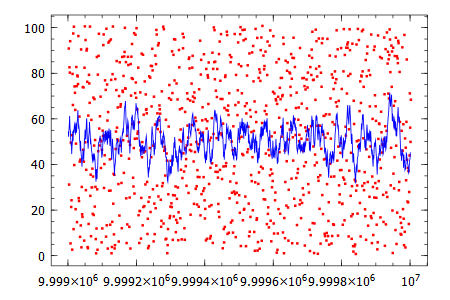

In [21]:
@manipulate for k=1:1000:20000000
    plot(collect(k:k+1000),A[k:k+1000],"r.",
        collect(k:k+1000),X[k:k+1000],"b")
end

### Remark
More details about optimizing your programs are given in the [Profiling Notebook]().

## Pre-allocating output

The following example is from [Pre-allocating outputs](http://julia.readthedocs.org/en/latest/manual/performance-tips/#pre-allocating-outputs). The functions `loopinc()` and `loopinc_prealloc()` both compute $\sum_{i=2}^{10000001}i$, the second one being 10 times faster: 

In [22]:
function xinc(x)
    return [x, x+1, x+2]
end

function loopinc()
    y = 0
    for i = 1:10^7
        ret = xinc(i)
        y += ret[2]
    end
    y
end

function xinc!{T}(ret::AbstractVector{T}, x::T)
    ret[1] = x
    ret[2] = x+1
    ret[3] = x+2
    nothing
end

function loopinc_prealloc()
    ret = Array(Int, 3)
    y = 0
    for i = 1:10^7
        xinc!(ret, i)
        y += ret[2]
    end
    y
end

loopinc_prealloc (generic function with 1 method)

In [23]:
@time loopinc()

  0.928169 seconds (40.01 M allocations: 1.490 GB, 12.52% gc time)


50000015000000

In [24]:
@time loopinc_prealloc() # After the second run

  0.059289 seconds (2.71 k allocations: 130.040 KB)


50000015000000

## Memory access

The following example is from [Access arrays in memory order, along columns](http://julia.readthedocs.org/en/latest/manual/performance-tips/#access-arrays-in-memory-order-along-columns).

Multidimensional arrays in Julia are stored in column-major order, which means that arrays are stacked one column at a time. This convention for ordering arrays is common in many languages like Fortran, Matlab, and R (to name a few). The alternative to column-major ordering is row-major ordering, which is the convention adopted by C and Python (numpy) among other languages. The ordering can be verified using the `vec()` function or the syntax `[:]`:

In [25]:
B = rand(0:9,4,3)

4×3 Array{Int64,2}:
 2  6  5
 7  9  8
 1  6  8
 7  8  7

In [26]:
B[:]

12-element Array{Int64,1}:
 2
 7
 1
 7
 6
 9
 6
 8
 5
 8
 8
 7

In [27]:
vec(B)

12-element Array{Int64,1}:
 2
 7
 1
 7
 6
 9
 6
 8
 5
 8
 8
 7

The ordering of arrays can have significant performance effects when looping over arrays. Loops should be organized such that the subsequent accessed elements are close to each other in physical memory.

The following functions accept a `Vector` and and return a square `Array` with the rows or the columns filled with copies of the input vector, respectively.

In [28]:
function copy_cols{T}(x::Vector{T})
    n = size(x, 1)
    out = Array(eltype(x), n, n)
    for i=1:n
        out[:, i] = x
    end
    out
end

function copy_rows{T}(x::Vector{T})
    n = size(x, 1)
    out = Array(eltype(x), n, n)
    for i=1:n
        out[i, :] = x
    end
    out
end

copy_rows (generic function with 1 method)

In [29]:
copy_cols([1.0,2])
copy_rows([1.0,2])

2×2 Array{Float64,2}:
 1.0  2.0
 1.0  2.0

In [30]:
x=rand(5000) # generate a random vector

5000-element Array{Float64,1}:
 0.116745 
 0.99852  
 0.862776 
 0.526826 
 0.0704964
 0.524004 
 0.597357 
 0.621508 
 0.699756 
 0.25245  
 0.957621 
 0.554104 
 0.736546 
 ⋮        
 0.6957   
 0.434595 
 0.473902 
 0.677786 
 0.598229 
 0.790179 
 0.775716 
 0.398999 
 0.708022 
 0.688725 
 0.504619 
 0.103703 

In [31]:
@time C=copy_cols(x)  # We generate a large matrix

  0.105329 seconds (4.50 k allocations: 190.804 MB, 7.04% gc time)


5000×5000 Array{Float64,2}:
 0.116745   0.116745   0.116745   …  0.116745   0.116745   0.116745 
 0.99852    0.99852    0.99852       0.99852    0.99852    0.99852  
 0.862776   0.862776   0.862776      0.862776   0.862776   0.862776 
 0.526826   0.526826   0.526826      0.526826   0.526826   0.526826 
 0.0704964  0.0704964  0.0704964     0.0704964  0.0704964  0.0704964
 0.524004   0.524004   0.524004   …  0.524004   0.524004   0.524004 
 0.597357   0.597357   0.597357      0.597357   0.597357   0.597357 
 0.621508   0.621508   0.621508      0.621508   0.621508   0.621508 
 0.699756   0.699756   0.699756      0.699756   0.699756   0.699756 
 0.25245    0.25245    0.25245       0.25245    0.25245    0.25245  
 0.957621   0.957621   0.957621   …  0.957621   0.957621   0.957621 
 0.554104   0.554104   0.554104      0.554104   0.554104   0.554104 
 0.736546   0.736546   0.736546      0.736546   0.736546   0.736546 
 ⋮                                ⋱                                 
 0.695

In [32]:
@time D=copy_rows(x) # This is several times slower

  0.324319 seconds (4.50 k allocations: 190.804 MB, 9.75% gc time)


5000×5000 Array{Float64,2}:
 0.116745  0.99852  0.862776  0.526826  …  0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826     0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826     0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826     0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826     0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826  …  0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826     0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826     0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826     0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826     0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826  …  0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826     0.688725  0.504619  0.103703
 0.116745  0.99852  0.862776  0.526826     0.688725  0.504619  0.103703
 ⋮                                  

### Remark
There is also a built-in function `repmat()`:

In [33]:
?repmat

search: repmat



```
repmat(A, n, m)
```

Construct a matrix by repeating the given matrix `n` times in dimension 1 and `m` times in dimension 2.


In [34]:
@time C1=repmat(x,1,5000)

  0.231033 seconds (37.95 k allocations: 192.221 MB, 35.44% gc time)


5000×5000 Array{Float64,2}:
 0.116745   0.116745   0.116745   …  0.116745   0.116745   0.116745 
 0.99852    0.99852    0.99852       0.99852    0.99852    0.99852  
 0.862776   0.862776   0.862776      0.862776   0.862776   0.862776 
 0.526826   0.526826   0.526826      0.526826   0.526826   0.526826 
 0.0704964  0.0704964  0.0704964     0.0704964  0.0704964  0.0704964
 0.524004   0.524004   0.524004   …  0.524004   0.524004   0.524004 
 0.597357   0.597357   0.597357      0.597357   0.597357   0.597357 
 0.621508   0.621508   0.621508      0.621508   0.621508   0.621508 
 0.699756   0.699756   0.699756      0.699756   0.699756   0.699756 
 0.25245    0.25245    0.25245       0.25245    0.25245    0.25245  
 0.957621   0.957621   0.957621   …  0.957621   0.957621   0.957621 
 0.554104   0.554104   0.554104      0.554104   0.554104   0.554104 
 0.736546   0.736546   0.736546      0.736546   0.736546   0.736546 
 ⋮                                ⋱                                 
 0.695